# S&P 500 Price Data Exploration 2010-2023

The first step in increasing the data for our model will be expanding the number of years we examine. Instead of just 2018, we are going to look at the last 14 completed years. This document does not incorporate any of our NLP work but instead just examines how the S&P500 index has behaved over these years.

### Data and Imports
Will be using pretty standard packages for this data exploration, will be using pandas for manipulation and matplotlib and plotly for visualization. The data used is daily historical price data from yahoo finance.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import plotly.graph_objects as go
import csv
from datetime import datetime
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
%matplotlib inline

In [2]:
stock_data = pd.read_csv('spy_daily_historical.csv')

Also going to add a column to this df to get the price change (close - open) and price change percent for each given day and switch the date to a datetime object.

In [3]:
stock_data['Price Change'] = stock_data['Close'] - stock_data['Open']
stock_data['Price Change %'] = (stock_data['Price Change'] / stock_data['Open']) * 100
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

### S&P 500 Price Movement
First I will plot just general price movement over the time window so we can just get a general understanding of the movement trends of this index fund.

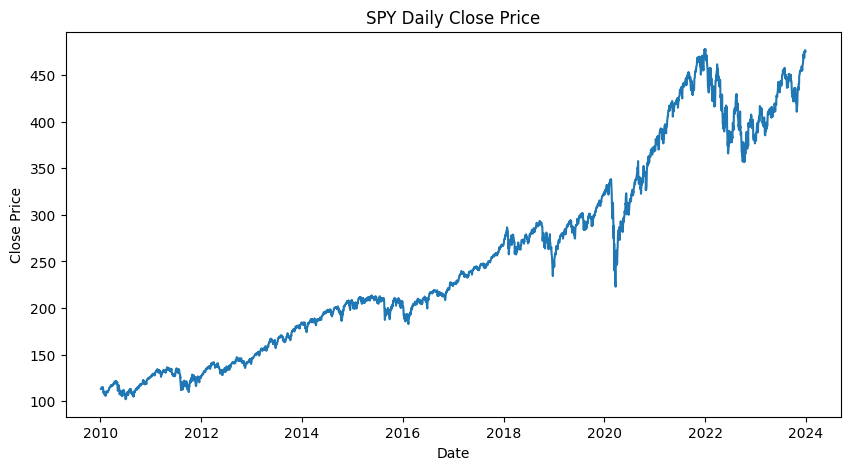

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(stock_data['Date'], stock_data['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('SPY Daily Close Price')
plt.show()

Daily Price Change Distribution:

<Axes: >

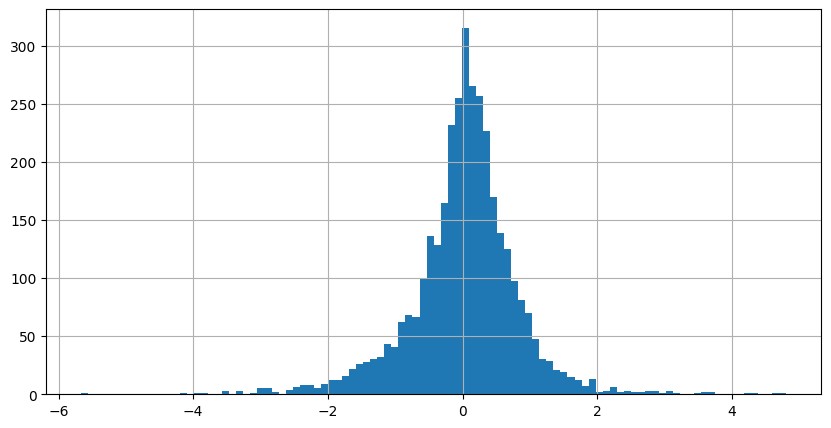

In [5]:
stock_data['Price Change %'].hist(bins=100, figsize=(10, 5))

In [6]:
stock_data['Price Change %'].describe()

count    3522.000000
mean        0.022538
std         0.808701
min        -5.661154
25%        -0.330550
50%         0.059920
75%         0.429011
max         4.799407
Name: Price Change %, dtype: float64

Create quarterly df to plot based on quarter:

In [7]:
stock_data['Quarter'] = stock_data['Date'].dt.year.astype(str) + ' Q' + stock_data['Date'].dt.quarter.astype(str)

quarterly_data = stock_data.groupby('Quarter').agg({'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last', 'Volume': 'sum', 'Price Change': 'sum', 'Price Change %': 'sum'}).reset_index()
quarterly_data.tail(2)

,Quarter,Open,High,Low,Close,Volume,Price Change,Price Change %
54,2023 Q3,442.920013,459.440002,422.290009,427.480011,4718070300,-22.23999,-4.923921
55,2023 Q4,426.619995,477.549988,409.209991,475.309998,5142218400,27.76004,6.201758


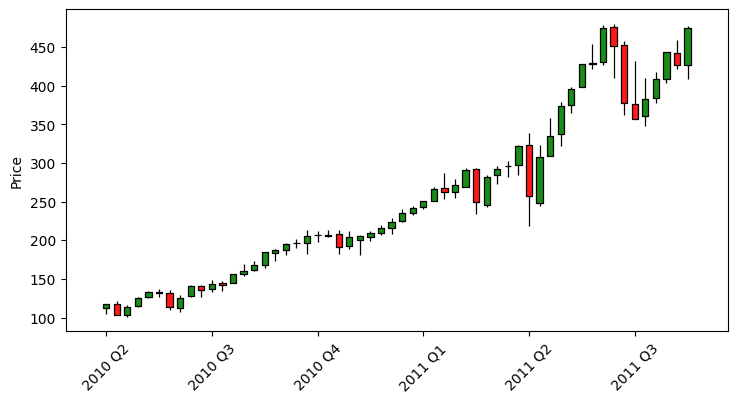

In [8]:
quarterly_data.index = pd.date_range(start='2010-01-01', periods=len(quarterly_data), freq='QE')

mc = mpf.make_marketcolors(up='g',down='r')
s  = mpf.make_mpf_style(marketcolors=mc)
fig, axes = mpf.plot(
    quarterly_data,
    type='candle',
    style=s,
    figscale=0.8,
    figratio=(2,1),
    returnfig=True
)
ignore = axes[0].set_xticklabels(quarterly_data['Quarter'])

Quarterly Price Change Distribution:

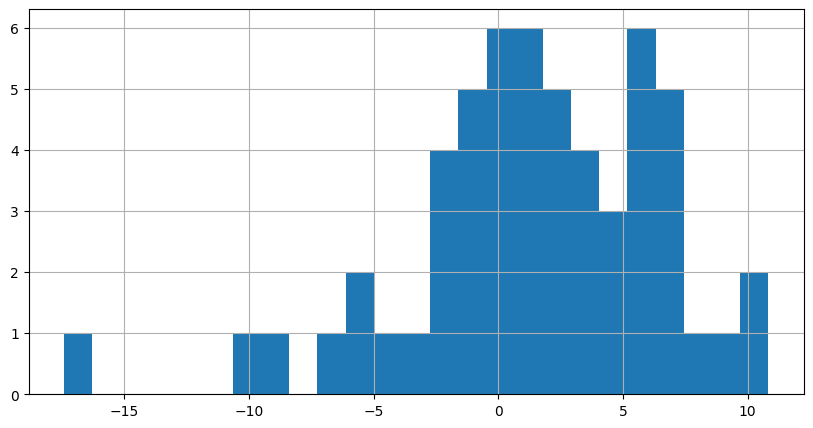

In [15]:
ignore = quarterly_data['Price Change %'].hist(bins=25, figsize=(10, 5))

In [10]:
quarterly_data['Price Change %'].describe()

count    56.000000
mean      1.417466
std       5.179505
min     -17.418811
25%      -1.260756
50%       1.285546
75%       5.301819
max      10.834366
Name: Price Change %, dtype: float64

Price Change Distributions By Quarter:

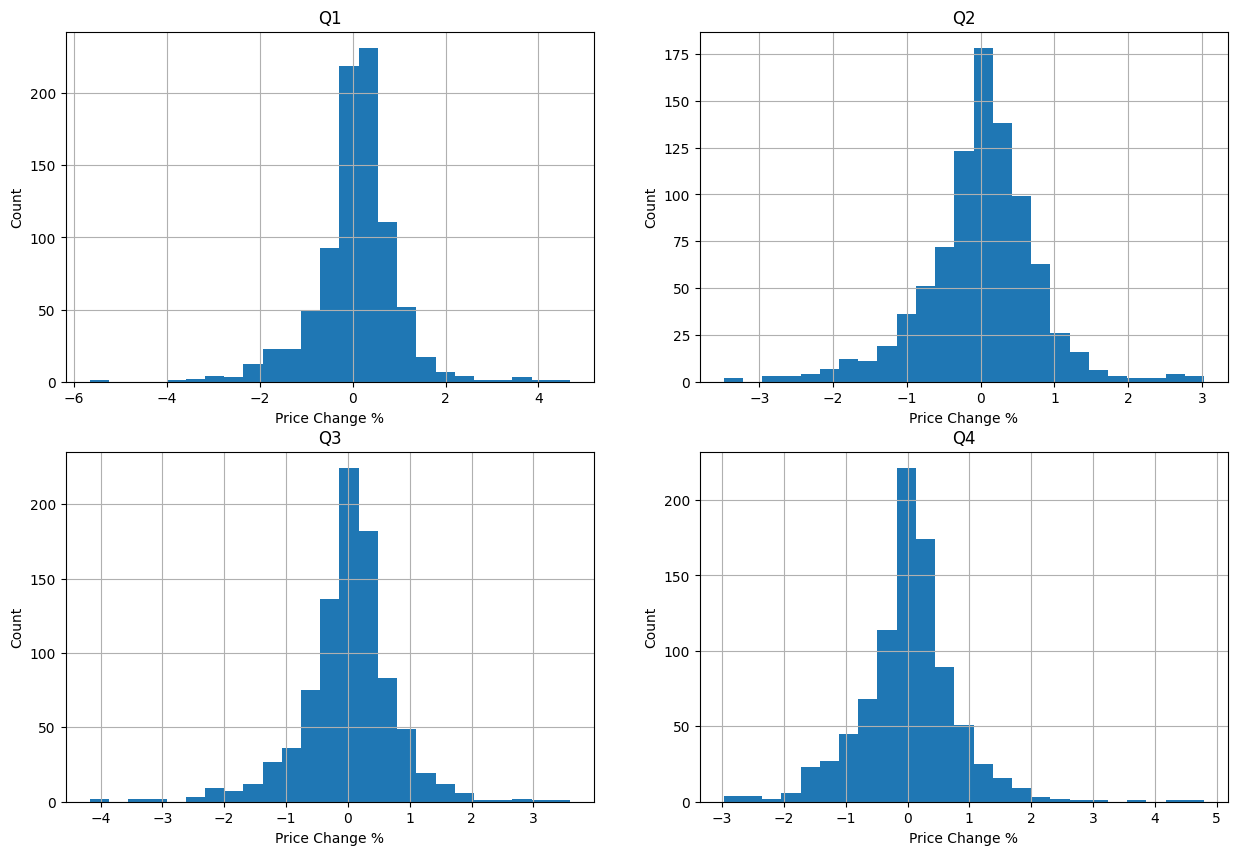

In [17]:
stock_data['Q'] = stock_data['Date'].dt.quarter

# create a 4 histograms for price change distribution by quarter and plot side by side
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
for i in range(1, 5):
    data = stock_data[stock_data['Q'] == i]
    data['Price Change %'].hist(bins=25, ax=axs[(i-1)//2, (i-1)%2])
    axs[(i-1)//2, (i-1)%2].set_title(f'Q{i}')
    axs[(i-1)//2, (i-1)%2].set_xlabel('Price Change %')
    axs[(i-1)//2, (i-1)%2].set_ylabel('Count')

### Price Change Classification Exploration
Because our project mostly revolves around price change classification (predicting whether a stock will go up or down) I will now try to discover some trends having to do with classifying a stock as up or down, up down or neutral, and group by quarter.

In [11]:
price_change = stock_data['Price Change %']
positive = price_change[price_change > 0].count()
negative = price_change[price_change < 0].count()

fig = go.Figure(
    data=[
        go.Bar(name='Positive', x=['Positive'], y=[positive]),
        go.Bar(name='Negative', x=['Negative'], y=[negative]),
        ]
    )
fig.update_layout(
    barmode='stack',
    title='Count of Positive and Negative Price Changes',
    xaxis_title='Price Change',
    yaxis_title='Count'
    )
fig.show()

In [12]:
positive = price_change[price_change > 0.25].count()
neutral = price_change[(price_change >= -0.25) & (price_change <= 0.25)].count()
negative = price_change[price_change < -0.25].count()

fig = go.Figure(
    data=[
        go.Bar(name='Positive', x=['Positive'], y=[positive]),
        go.Bar(name='Neutral', x=['Neutral'], y=[neutral]),
        go.Bar(name='Negative', x=['Negative'], y=[negative]),
        ]
    )
fig.update_layout(
    barmode='stack',
    title='Breakdown of Price Changes',
    xaxis_title='Price Change',
    yaxis_title='Count'
    )
fig.show()

In [13]:
positive = price_change[price_change > 1].count()
neutral = price_change[(price_change >= -1) & (price_change <= 1)].count()
negative = price_change[price_change < -1].count()

fig = go.Figure(
    data=[
        go.Bar(name='> 1%', x=['Positive'], y=[positive]),
        go.Bar(name='Neutral', x=['Neutral'], y=[neutral]),
        go.Bar(name='<-1%', x=['Negative'], y=[negative]),
        ]
    )
fig.update_layout(
    barmode='stack',
    title='Count of Strong Price Changes (>1%)',
    xaxis_title='Price Change',
    yaxis_title='Count'
    )
fig.show()

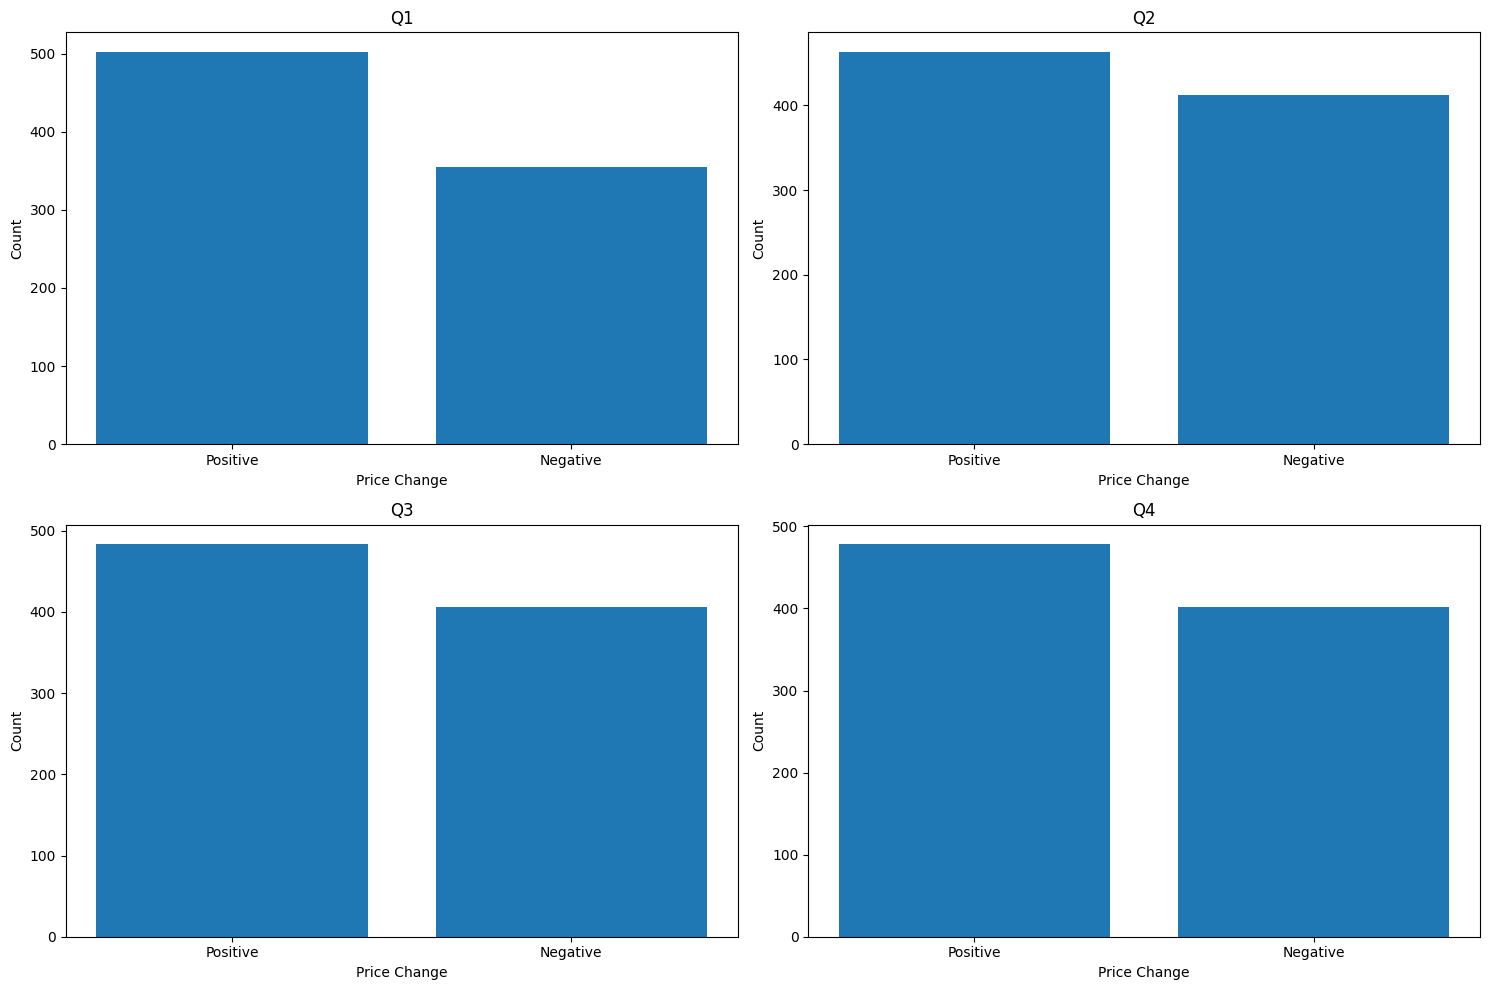

In [20]:
# create a 4 bar charts for positive vs negative change by quarter and plot side by side
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(1, 5):
    data = stock_data[stock_data['Q'] == i]
    positive = data[data['Price Change %'] > 0]
    negative = data[data['Price Change %'] < 0]

    axs[(i-1)//2, (i-1)%2].bar(['Positive', 'Negative'], [len(positive), len(negative)])
    axs[(i-1)//2, (i-1)%2].set_title(f'Q{i}')
    axs[(i-1)//2, (i-1)%2].set_xlabel('Price Change')
    axs[(i-1)//2, (i-1)%2].set_ylabel('Count')

plt.tight_layout()
plt.show()

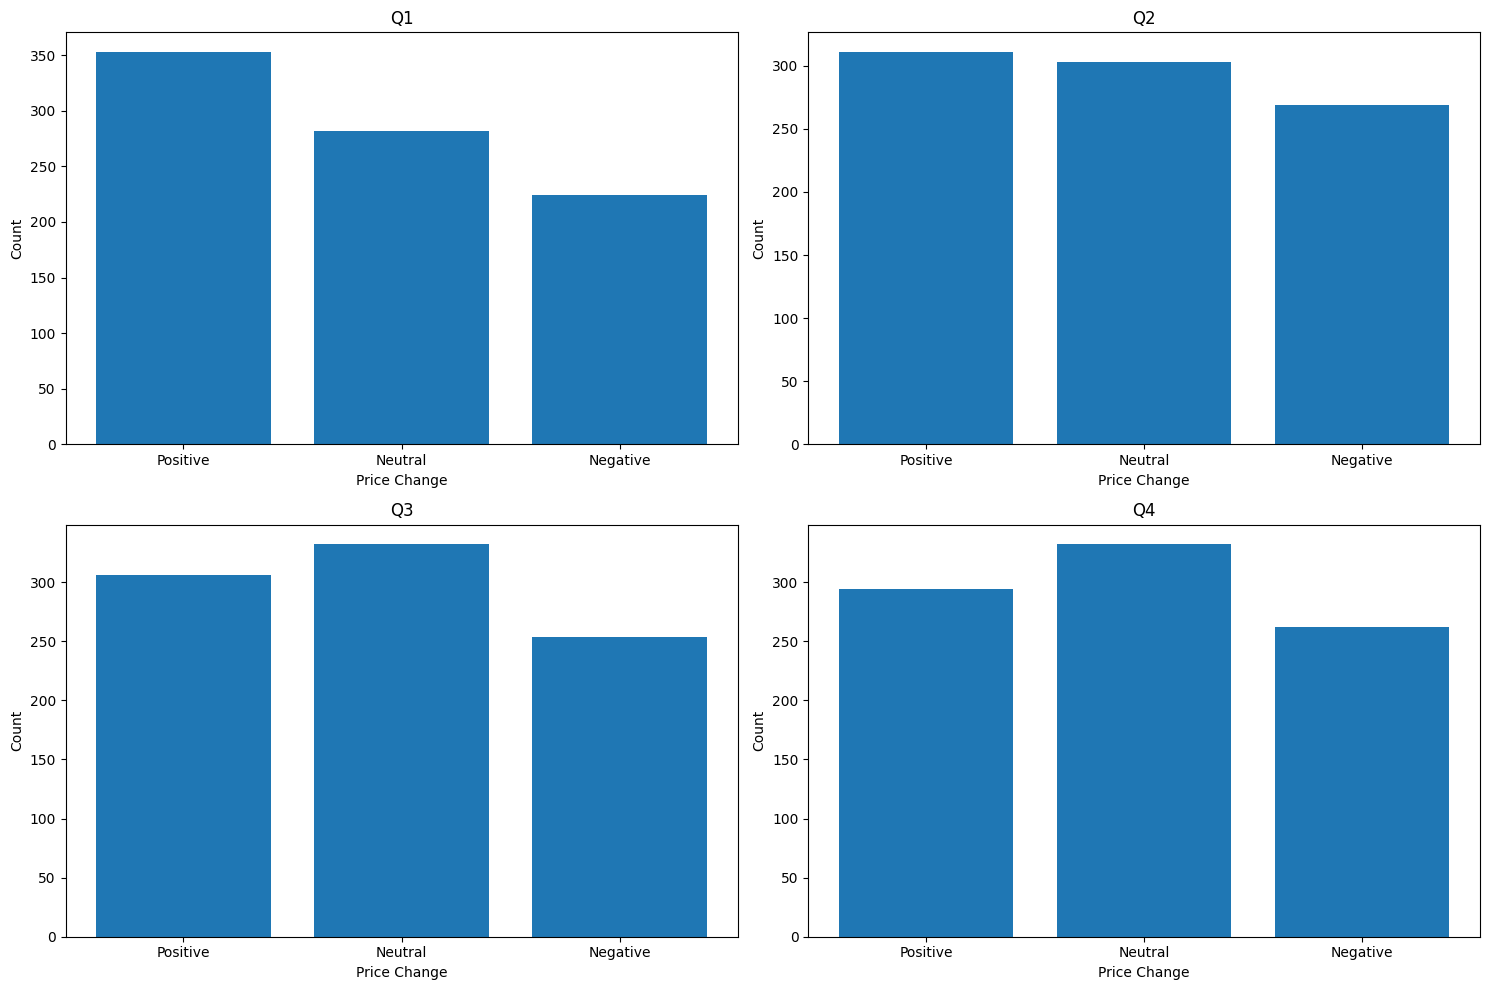

In [22]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i in range(1, 5):
    data = stock_data[stock_data['Q'] == i]
    positive = data[data['Price Change %'] > 0.25]
    negative = data[data['Price Change %'] < -0.25]
    neutral = data[(data['Price Change %'] >= -0.25) & (data['Price Change %'] <= 0.25)]

    axs[(i-1)//2, (i-1)%2].bar(['Positive', 'Neutral', 'Negative'], [len(positive), len(neutral), len(negative)])
    axs[(i-1)//2, (i-1)%2].set_title(f'Q{i}')
    axs[(i-1)//2, (i-1)%2].set_xlabel('Price Change')
    axs[(i-1)//2, (i-1)%2].set_ylabel('Count')

plt.tight_layout()
plt.show()

### Insights:
After exploring the S&P 500 data, I have the following insights:
* There is a strong trend upward over the examined years; however, this trend is slow with an average daily change of +0.022% and an average quarterly change of +1.4%.
* Days that the S&P500 index goes up are only slightly more common than days when the index goes down.
* Days that the S&P 500 index goes down big (decreases more than 1%) are slightly more common than days where the index goes up big.
* A given quarter seems to have very little impact on the index price change except that there seems to be a slight trend that the index appears to perform slightly better in the first quarter.